# Practical 2: Convolutional Networks


## Introduction
In this practical we will cover the basics of convolutional neural networks, or "ConvNets". ConvNets were invented in the late 1980s/early 1990s, and have had tremendous success especially with vision (although they have also been used to great success in speech processing pipelines, and more recently, for machine translation).

## Learning Objectives
* Be able to explain what a convolutional layer does and how it's different from a fully-connected layer 
* Understand  the assumptions and trade-offs that are being made when using convolutional architectures
* Be able to build a convolutional architecture using Tensorflow and Keras Layers
* Be able to use Keras to train a model on a dataset
* Implement either batch normalisation or a very small residual network

## Running on GPU
For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelelator" box. This is all you need to do, Colab and Tensorflow will take care of the rest! 

In [1]:
#@title Imports (RUN ME!) { display-mode: "form" }

# TODO: Swallow output
!pip -q install pydot_ng
!pip -q install graphviz
!apt install graphviz > /dev/null

from __future__ import absolute_import, division, print_function

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

try:
  tf.enable_eager_execution()
  print('Running in Eager mode.')
except ValueError:
  print('Already running in Eager mode')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Running in Eager mode.


## Convolutional Architectures
When modelling an image using a regular feed-forward network, we find that the number of model parameters grows exponentially. For example, the tiny network we built in Practical 1 already had over 100,000 parameters!

**QUESTION**: How many parameters would there be in a feed-forward network with 2 hidden layers consisting of 512 and 256 neurons respectively, an output size of 10 and an input image of shape [32, 32, 3]?

ConvNets address this model parameter issue by exploiting structure in the inputs to the network (in particular, by making the assumption that the input is a 3D volume, which applies to images for example). The two key differences between a ConvNet and a Feed-forward network are:

* ConvNets have neurons that are arranged in 3 dimensions: width, height, depth (depth here means the depth of an activation volume, not the depth of a deep neural network!)
* The neurons in each layer are only connected to a small region of the layer before it.

**QUESTION**: Unfortunately there is no such thing as a free lunch. What do you think the trade-off a ConvNet makes for the reduction in memory required by fewer parameters?

Generally a ConvNet architecture is made up of different types of layers, the most common being convolutional layers, pooling layers and fully connected layers that we encountered in the last practical.

### Aside: The rise of deep convolutional architectures

ConvNet architectures were key to the tremendous success of deep learning in machine vision. In particular, the first deep learning model to win the ImageNet competition in 2012 was called AlexNet (after Alex Krizhevsky, one of its inventors). It had 5 convolutional layers followed by 3 fully connected layers. Later winners included GoogLeNet and ResNet. If you're curious, have a look at [this link](https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba) for a great summary of different ConvNet archiectures.

### Convolutional Layers

A convolutional layer maps an input volume* to an output volume through a set of learnable filters, which make up the parameters of the layer. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. (Eg: A filter in the first layer of a ConvNet might have size [5, 5, 3]). During the forward pass, we convolve ("slide") each filter across the width and height of the input volume and compute dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Each convolutional layer will have a set of filters, and each of them will produce a separate 2-dimensional activation map. We will stack these activation maps along the depth dimension to produce the output volume.

By using these filters which map to a small sub-volume of the input, we can to a large extent, control the parameter explosion that we would get with a (fully connected) feed-forward network. This **parameter sharing** actually also tends to improve the performance of the model on inputs like natural images because it provides the model with some limited **translation invariance**. Translation invariance means that if the image (or a feature in the image) is translated (moved), the model will not be significantly affected. Think about why this is the case!

The following animation illustrates these ideas, make sure you understand them!

![Convolution Animation](https://i.stack.imgur.com/FjvuN.gif)

*An input volume refers to a 3 dimensional input. For example, a colour image is often represented as a 3 dimensional tensor of shape [width, height, channels] where channels refers to the colour values. A common colour encoding is RGB which has a value between 0 and 256 for each of the red, green and blue channels.

The hyper-parameters of a convolutional layer are as follows:
* **Filters** defines the number of filters in the layer
* **Kernel Size** defines the width and height of the filters (kernels) in the layer. Note that kernels always have the same depth as the inputs to the layer.
* **Stride** defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used.
* **Padding** refers to the addition of 0 pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.

Lets look at a very simple, dummy example to see how the values of the hyper-parameters affect the output size of a convolutional layer.

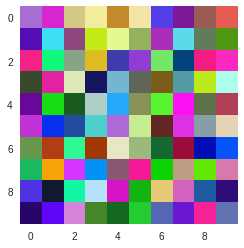

In [3]:
# Create a random colour "image" of shape 10x10 with a depth of 3 (for red, green and blue)
dummy_input = np.random.uniform(size=[10, 10, 3])
fig, ax = plt.subplots(1, 1)
plt.imshow(dummy_input)
ax.grid(False)
print('Input shape: {}'.format(dummy_input.shape))

Now adjust the hyperparameters using the sliders on the right and see how the output dimension changes

In [4]:
#@title Convolutional layer parameters {run: "auto"}
filters = 3  #@param { type: "slider", min:0, max: 10, step: 1 }
kernel_size = 2 #@param { type: "slider", min:1, max: 10, step: 1 }
stride = 1 #@param { type: "slider", min:1, max: 3, step: 1 }

conv_layer = tf.keras.layers.Conv2D(
    filters=filters, 
    kernel_size=kernel_size, 
    strides=stride,
    padding="valid",
    input_shape=[10, 10, 3])

# Convert the image to a tensor and add an extra batch dimension which
# the convolutional layer expects.
input_tensor = tf.convert_to_tensor(dummy_input[None, :, :, :])
convoluted = conv_layer(input_tensor)

print('The output dimension is:')
list([d.value for d in convoluted.shape])[1:]

The output dimension is:


[9, 9, 3]

#### Question
Can you come up with a formula for the output shape given the input shape, the hyperparameters of the layer and assuming no padding? 

### (Max) Pooling
The purpose of a pooling layer is to is to reduce the spatial size of the representation and therefore control the number of parameters in the network. A pooling layer has no trainable parameters itself. It applies some 2D aggegation operation (usually a MAX, but others like average may also be used) to regions of the input volume. This is done independently for each depth dimension of the input. For example, a 2x2 max pooling operation with a stride of 2, downsamples every depth slice of the input by 2 along both the width and height.

#### Question
Do 2x2 max-pooling by hand, with a stride of 2, on the following 2D input. What is the size of the output?

\begin{bmatrix}
  9 & 5 & 4 & 5 & 6 & 4 \\
  6 & 6 & 3 & 5 & 8 & 2 \\
  4 & 6 & 9 & 1 & 3 & 6 \\
  9 & 7 & 1 & 5 & 8 & 1 \\
  4 & 9 & 9 & 5 & 7 & 3 \\
  7 & 3 & 6 & 4 & 9 & 1 
\end{bmatrix}


Reveal the cell below by double-clicking and running it, to check your answer when you're done!

In [0]:
#@title Answer { display-mode: "form" }
X = np.array([[9, 5, 4, 5, 6, 4],
              [6, 6, 3, 5, 8, 2],
              [4, 6, 9, 1, 3, 6],
              [9, 7, 1, 5, 8, 1],
              [4, 9, 9, 5, 7, 3],
              [7, 3, 6, 4, 9, 1]])

max_pool_layer = tf.keras.layers.MaxPooling2D((2, 2), strides=2)
max_pool_layer(tf.convert_to_tensor(X[None, :, :, None])).numpy().squeeze()


## The CIFAR10 Dataset
Now that we understand convolutional, max-pool and feed-forward layers, we can combine these ingedrients to build a ConvNet classifier for images. For this practical, we will use the colour image dataset CIFAR10 which consists of 50000 training images and 10000 test images. As we did in Practical 1, we take 10,000 images from the training set to form a validation set and visualise some example images.

In [2]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170508288/170498071 [==============================] - 23s 0us/step


In [0]:
# Take the last 10000 images from the training set to form a validation set 
train_labels = train_labels.squeeze()
validation_images = train_images[40000:, :, :]
validation_labels = train_labels[40000:]
train_images = train_images[:40000, :, :]
train_labels = train_labels[:40000]

What are the shapes and data-types of train_images and train_labels?

In [4]:
print('train_images.shape = {}, data-type = {}'.format(train_images.shape, train_images.dtype))
print('train_labels.shape = {}, data-type = {}'.format(train_labels.shape, train_labels.dtype))

print('validation_images.shape = {}, data-type = {}'.format(validation_images.shape, validation_images.dtype))
print('validation_labels.shape = {}, data-type = {}'.format(validation_labels.shape, validation_labels.dtype))

train_images.shape = (40000, 32, 32, 3), data-type = uint8
train_labels.shape = (40000,), data-type = uint8
validation_images.shape = (10000, 32, 32, 3), data-type = uint8
validation_labels.shape = (10000,), data-type = uint8


### Visualise examples from the dataset
Run the cell below multiple times to see various images. (They might look a bit blurry because we've zoomed the small images)

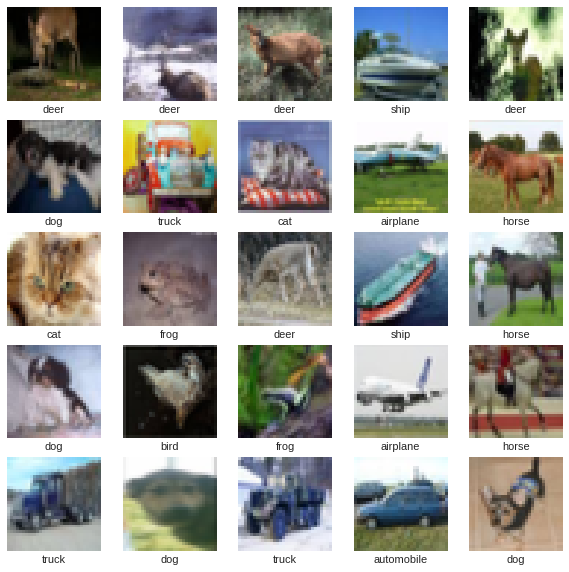

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 40000)
  plt.imshow(train_images[img_index])
  plt.xlabel(cifar_labels[train_labels[img_index]])

## A ConvNet Classifier
Finally, we build a simple convolutional architecture to classify the CIFAR images.

In [0]:
# Define the convolutinal part of the model architecture using Keras Layers.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])


How many parameters are there in the convolutional part of the architecture?

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)         221312    
__________

Now we add a fully-connected part

In [0]:
model.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3D volume down into a single vector.
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)         221312    
__________

###Visualizing the model

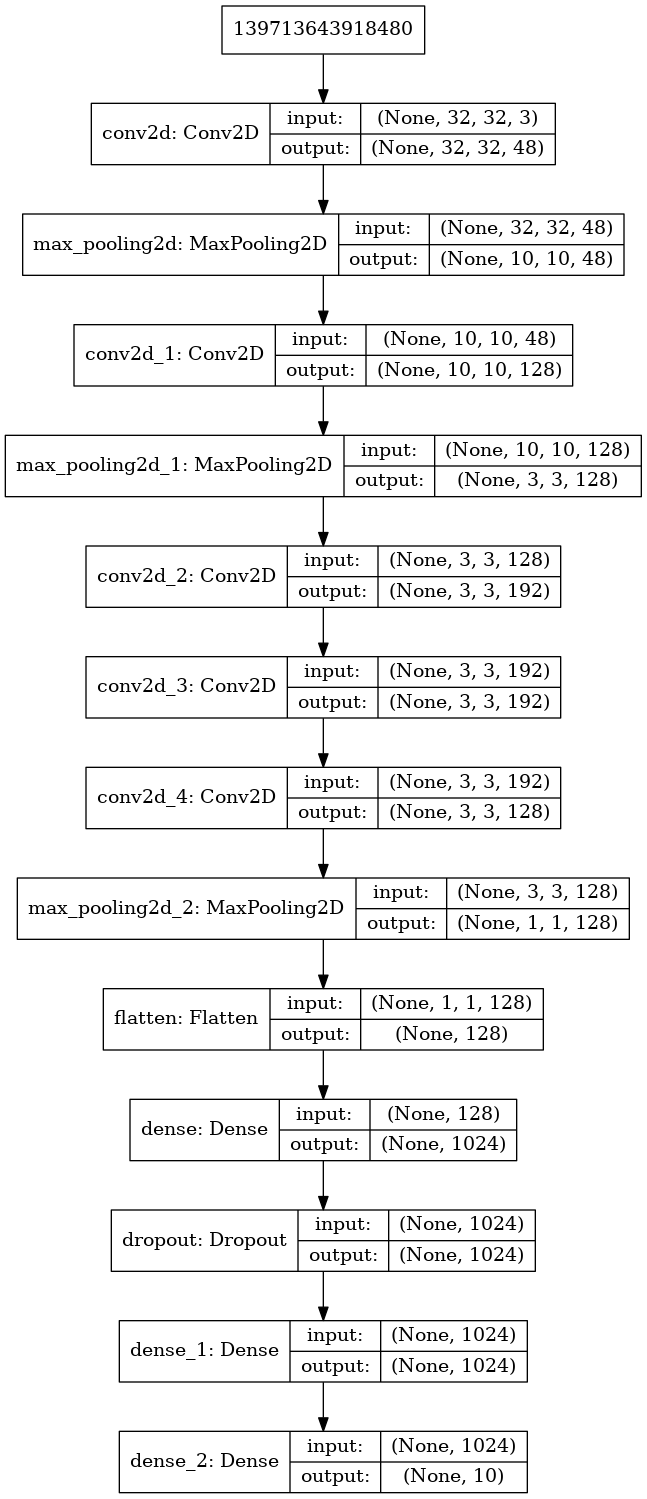

In [9]:
tf.keras.utils.plot_model(model, to_file='small_lenet.png', show_shapes=True, show_layer_names=True)
display.display(display.Image('small_lenet.png'))


### Training and Validating the model
Last practical we wrote out the dataset pipeline, loss function and training-loop to give you a good appreciation for how it works. This time, we use the training loop built-in to Keras. For simple, standard datasets like CIFAR, doing it this way will work fine, but it's important to know what goes on under the hood because you may need to write some or all of the steps out manually when working with more complex datasets! 

In [14]:
batch_size = 128
num_epochs = 10  # The number of epochs to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# The fit function allows you to fit the compiled model to some training data
model.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 20s 494us/step - loss: 1.7836 - acc: 0.3597 - val_loss: 1.3308 - val_acc: 0.5136
Epoch 2/10
40000/40000 [==============================] - 19s 481us/step - loss: 1.2728 - acc: 0.5440 - val_loss: 1.1727 - val_acc: 0.5926
Epoch 3/10
40000/40000 [==============================] - 19s 466us/step - loss: 1.0973 - acc: 0.6135 - val_loss: 1.1834 - val_acc: 0.5813
Epoch 4/10
40000/40000 [==============================] - 19s 480us/step - loss: 0.9681 - acc: 0.6631 - val_loss: 1.0520 - val_acc: 0.6387
Epoch 5/10
40000/40000 [==============================] - 19s 480us/step - loss: 0.8808 - acc: 0.6918 - val_loss: 1.0265 - val_acc: 0.6423
Epoch 6/10
40000/40000 [==============================] - 19s 480us/step - loss: 0.8018 - acc: 0.7189 - val_loss: 0.9642 - val_acc: 0.6733
Epoch 7/10
40000/40000 [==============================] - 19s 480us/step - loss: 0.7357 - acc: 0.7451 - val_loss: 0.

### Test performance
Finally, we evaluate how well the model does on the held-out test-set

In [15]:
metric_values = model.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

10000/10000 [==============================] - 3s 328us/step
Final TEST performance
loss: 1.11195406628
acc: 0.6595


### Classifying examples
We now use our trained model to classify a sample of 25 images from the test set. We pass these 25 images to the  ```model.predict``` function, which returns a [25, 10] dimensional matrix. The entry at position $(i, j)$ of this matrix contains the probability that image $i$ belongs to class $j$. We obtain the most-likely prediction using the ```np.argmax``` function which returns the index of the maximum entry along the columns. Finally, we plot the result with the prediction and prediction probability labelled underneath the image and true label on the side. 

In [0]:
img_indices = np.random.randint(0, len(test_images), size=[25])
sample_test_images = test_images[img_indices]
sample_test_labels = [cifar_labels[i] for i in test_labels[img_indices].squeeze()]

predictions = model.predict(sample_test_images)
max_prediction = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

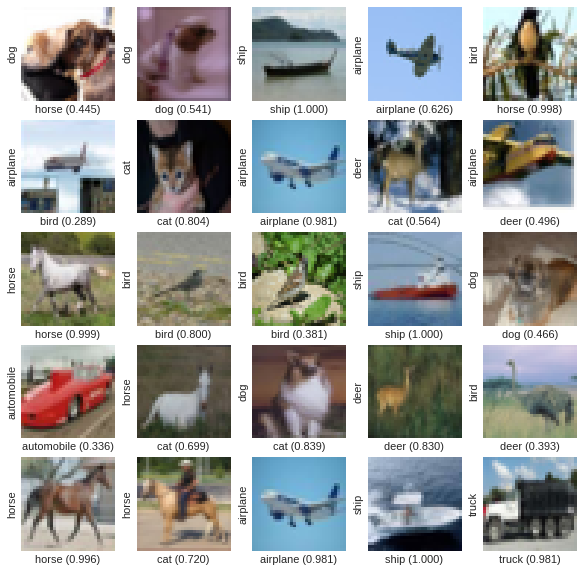

In [22]:
plt.figure(figsize=(10,10))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(cifar_labels[prediction], prob))
  plt.ylabel('{}'.format(true_label))
  

### Question
What do you think of the model's predictions? Looking at the model's certainty (the probability assigned to the predicted class), look for examples of the following cases:
1. The model was correct with high certainty
2. The model was correct with low certainty
3. The model was incorrect with high certainty
4. The model was incorrect with low certainty

What do you think the (relative) loss values would be in those cases? 


## Your Tasks
2. [**ALL**] Implement BATCH NORMALISATION ([Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) and [research paper](http://proceedings.mlr.press/v37/ioffe15.pdf)) to improve the model's generalisation.
3. [**ADVANCED**] Read about Residual networks ([original paper](https://arxiv.org/pdf/1512.03385.pdf), ) and add **shortcut connections** to the model architecture. Try to build a simple reusable "residual block" as a [Keras Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model). 